## Contexte :
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

#Data Cleaning et Anlayse exploratoire

Import des bibliothèques 

In [195]:
!pip install plotly  #Installation de plotly pour l'affichage des certains graphiques

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [196]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go

Téléchargement du jeu de données

In [197]:
#data = pd.read_csv('https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv')
data = pd.read_csv("https://raw.githubusercontent.com/bachir151/stage/master/2016_Building_Energy_Benchmarking%20(1).csv")

In [198]:
display(data.head())
#display(data.columns.to_list())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Enlever tout ce qui est residentiel. Outliers ~ Quartile. ComplianceStatus variables à considérer. Type de classifier  : Regression linéaire, Lasso, Ridge, RandomForest, Boosting. 

Point d'attention : Corrélation entre variables. dataleak ~ fuite de données. corrélation entre feature et target. Normaliser les variables. 

Impact de energystar sur la qualité de la regression. 

### Choix des variables 

Après exploration de la liste des variables, nous en ont retenu deux : **TotalGHGEmissions** et **SiteEnergyUse(kBtu)** qui nous constituent les variables que nous allons essayer de prédire à partir d'autres varaibles qu'on aura choisi.

Ainsi notre étude sera initiée avec comme variables expliquuées TotalGHGEmissions, SiteEnergyUse(kBtu) et comme variables explicatives 

In [199]:
variables  =  ["OSEBuildingID","BuildingType", "PrimaryPropertyType","Address", "City","State","ZipCode","Latitude","Longitude", "DataYear","YearBuilt",
               "NumberofBuildings" , "NumberofFloors", "PropertyGFATotal", "SiteEUI(kBtu/sf)","PropertyGFAParking",
               "SiteEUIWN(kBtu/sf)",  "SiteEnergyUseWN(kBtu)", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ENERGYSTARScore", "ComplianceStatus", 
               "Outlier", "TotalGHGEmissions","GHGEmissionsIntensity" , "SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","PropertyGFABuilding(s)"
               ]

In [200]:
data1=data[variables]  

Notre étude ne portant que sur les bâtiments non déstinés à l'habitation, nous allons converver ceux-là et exclure les autres types de bâtiments du jeu de données.

In [201]:
data1['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Les bâtiments qui nous interessent sont ceux appartenant aux catégories "NonResidential" , "NonResidential COS", "SPS-District K-12" et "Nonresidential WA".Au total 1668 bâtiments composent ces 5 catégories.

In [202]:
data1[(data1['BuildingType']=='NonResidential') & (data1['PrimaryPropertyType']=='Low-Rise Multifamily')]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s)
644,19445,NonResidential,Low-Rise Multifamily,2108 N Pacific St.,Seattle,WA,98103.0,47.64859,-122.33311,2016,...,32.0,Compliant,NaN,25.60,0.28,1.997182e+06,0.0,252982.0,1744199.0,56986
2450,25674,NonResidential,Low-Rise Multifamily,916 E PIKE ST,Seattle,WA,98122.0,47.61427,-122.31977,2016,...,NaN,Non-Compliant,Low outlier,5.22,0.16,1.082004e+05,0.0,96830.0,11370.0,32100


In [203]:
data1["LargestPropertyUseType"].value_counts()

Multifamily Housing                                     1667
Office                                                   498
Non-Refrigerated Warehouse                               199
K-12 School                                              139
Other                                                    102
Retail Store                                              99
Hotel                                                     77
Worship Facility                                          71
Distribution Center                                       54
Senior Care Community                                     46
Supermarket/Grocery Store                                 41
Medical Office                                            41
Parking                                                   32
Other - Recreation                                        31
Self-Storage Facility                                     28
College/University                                        25
Residence Hall/Dormitory

In [204]:
display(data1[(data1["BuildingType"]=="NonResidential")  & (data1["LargestPropertyUseType"] == "Multifamily Housing")])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s)
164,264,NonResidential,Mixed Use Property,516 1st Ave W,Seattle,WA,98119.0,47.623900,-122.357560,2016,...,NaN,Compliant,NaN,92.91,0.84,1.055791e+07,0.0,418354.0,10139555.0,110785
644,19445,NonResidential,Low-Rise Multifamily,2108 N Pacific St.,Seattle,WA,98103.0,47.648590,-122.333110,2016,...,32.0,Compliant,NaN,25.60,0.28,1.997182e+06,0.0,252982.0,1744199.0,56986
1159,21122,NonResidential,Mixed Use Property,3424 Fremont Ave. N.,Seattle,WA,98103.0,47.650200,-122.349590,2016,...,NaN,Compliant,NaN,110.17,2.63,4.193371e+06,0.0,1754275.0,2439095.0,32601
1839,23562,NonResidential,Mixed Use Property,80 Yesler Way,Seattle,WA,98104.0,47.601950,-122.335160,2016,...,NaN,Compliant,NaN,5.37,0.12,7.697713e+05,0.0,0.0,769771.0,43878
2314,25222,NonResidential,Mixed Use Property,737 Olive Way,Seattle,WA,98101.0,47.613760,-122.334450,2016,...,65.0,Compliant,NaN,449.59,0.42,2.641677e+07,0.0,5752789.0,20663978.0,962428
2394,25522,NonResidential,Mixed Use Property,5401 26th Ave NE,Seattle,WA,98105.0,47.668270,-122.299780,2016,...,NaN,Compliant,NaN,34.62,1.07,1.391714e+06,0.0,540057.0,851657.0,25297
2450,25674,NonResidential,Low-Rise Multifamily,916 E PIKE ST,Seattle,WA,98122.0,47.614270,-122.319770,2016,...,NaN,Non-Compliant,Low outlier,5.22,0.16,1.082004e+05,0.0,96830.0,11370.0,32100
2748,26834,NonResidential,Mixed Use Property,525 MAYNARD AVE S,Seattle,WA,98104.0,47.597690,-122.325370,2016,...,NaN,Compliant,NaN,20.78,1.01,7.474569e+05,0.0,337398.0,410059.0,20620
3003,27838,NonResidential,Mixed Use Property,1600 E. Madison St.,Seattle,WA,98122.0,47.615540,-122.310980,2016,...,93.0,Compliant,NaN,83.65,1.58,3.392129e+06,0.0,1300504.0,2091625.0,38409
3041,27969,NonResidential,Mixed Use Property,1700 E Madison St,Seattle,WA,98122.0,47.616080,-122.309670,2016,...,100.0,Compliant,NaN,7.12,0.07,1.021755e+06,0.0,0.0,1021754.0,97229


Non compliant à éliminer 

Il y a 11 résidence non destinés à l'habitation mais qui sont en partiellement utilisés pour heberger des familles.

In [205]:
display(data1[ ((data1["BuildingType"]=="Campus") | (data1["BuildingType"]=="Nonresidential WA"))  & (data1["LargestPropertyUseType"] == "Multifamily Housing")])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s)
1300,21481,Campus,Low-Rise Multifamily,1525 FIrst Avenue,Seattle,WA,98101.0,47.60918,-122.34079,2016,...,NaN,Compliant,NaN,26.34,0.58,3778355.0,0.0,0.0,3778355.0,45500


1 bâtiment de type campus utilisé comme lieu d'habitat pour famille. 

On garde les bâtiments non destinés à l'habitation

In [206]:
data1 = data1[ (data1["BuildingType"]=="NonResidential") |  (data1["BuildingType"]=="Nonresidential COS") | (data1["BuildingType"]=="Campus") |(data1["BuildingType"]=="Nonresidential WA") ]

In [207]:
data1['BuildingType'].value_counts()

NonResidential        1460
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: BuildingType, dtype: int64

#### Suppression des doublons

In [208]:
data1[data1.duplicated(subset=['OSEBuildingID'], keep=False) == True].sort_values(by=['OSEBuildingID'])

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s)


In [209]:
data1 = data1.drop_duplicates(subset=["OSEBuildingID"], keep='first')

In [210]:
data1.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3371    False
3372    False
3373    False
3374    False
3375    False
Length: 1570, dtype: bool

Pas de doublons dans notre jeu de données

#### Conformité du type de chaque variable et recherche de valeur manquante

In [211]:
data1.dtypes

OSEBuildingID                     int64
BuildingType                     object
PrimaryPropertyType              object
Address                          object
City                             object
State                            object
ZipCode                         float64
Latitude                        float64
Longitude                       float64
DataYear                          int64
YearBuilt                         int64
NumberofBuildings               float64
NumberofFloors                    int64
PropertyGFATotal                  int64
SiteEUI(kBtu/sf)                float64
PropertyGFAParking                int64
SiteEUIWN(kBtu/sf)              float64
SiteEnergyUseWN(kBtu)           float64
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ENERGYSTARScore                 float64
ComplianceStatus                 object
Outlier                          object
TotalGHGEmissions               float64
GHGEmissionsIntensity           float64


In [212]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  2
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   3
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 3
SiteEnergyUseWN(kBtu)              3
LargestPropertyUseType             6
SecondLargestPropertyUseType     717
ENERGYSTARScore                  559
ComplianceStatus                   0
Outlier                         1554
TotalGHGEmissions                  2
GHGEmissionsIntensity              2
SiteEnergyUse(kBtu)                2
SteamUse(kBtu)                     2
N

Parmi les variables qui présentent des valeurs manquantes, seules les variables **ENERGYSTARScore** et **SiteEnergyUse(kBtu)** est une variable d'intêret majeur pour notre étude. Il va valoir choisir une méthode adaptée pour imputer les valeurs manquantes de cette variable. Mais avant cela, vérifions s'il n'y a pas de valeurs abberantes dans chaque colonne de notre jeu de données. 

Point d'attention sur les 2 variables +  la catégorie campus  voir effet suupression sur le modèle.

In [213]:
data1.Outlier.value_counts()
data1.ComplianceStatus.value_counts()

Compliant                       1538
Non-Compliant                     18
Error - Correct Default Data      13
Missing Data                       1
Name: ComplianceStatus, dtype: int64

#### Recherche de valeurs abberantes

In [214]:
data1[ (data1["OSEBuildingID"] <0) | (data1["OSEBuildingID"]==0) |  (data1["OSEBuildingID"]=="")]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s)


In [215]:
data1[ (data1["GHGEmissionsIntensity"] <=0) | (data1["ENERGYSTARScore"]<=0) |  (data1["Electricity(kBtu)"]<=0)] [['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking'
 ]]


,OSEBuildingID,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUI(kBtu/sf),LargestPropertyUseType,ENERGYSTARScore,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),PropertyGFABuilding(s),PropertyGFAParking
304,435,NonResidential,Other,1.0,6,1400000,NaN,Convention Center,NaN,Non-Compliant,NaN,0.00,0.00,0.000000e+00,0.0,0.0,0.0,1400000,0
426,23854,NonResidential,Restaurant,1.0,1,43728,263.200012,Restaurant,NaN,Compliant,NaN,611.19,13.98,1.150804e+07,0.0,11508035.0,0.0,43728,0
513,700,NonResidential,Supermarket / Grocery Store,1.0,1,57176,208.800003,Supermarket/Grocery Store,31.0,Compliant,NaN,0.00,0.00,1.252517e+07,0.0,0.0,0.0,57176,0
746,19776,NonResidential,Other,1.0,1,29924,0.000000,Other - Education,NaN,Missing Data,NaN,0.00,0.00,0.000000e+00,0.0,0.0,0.0,29924,0
1229,21315,NonResidential,Small- and Mid-Sized Office,1.0,3,57720,1.000000,Office,NaN,Non-Compliant,Low outlier,0.17,0.00,2.410550e+04,0.0,0.0,24105.0,57720,0
2189,24717,NonResidential,Other,1.0,3,27690,0.700000,Other,NaN,Non-Compliant,Low outlier,0.12,0.00,1.680890e+04,0.0,0.0,16809.0,27690,0
3206,49784,NonResidential,Small- and Mid-Sized Office,1.0,6,52000,7.100000,Office,100.0,Compliant,NaN,-0.80,-0.02,3.427261e+05,0.0,0.0,-115417.0,52000,0


Suppression des bâtiments dont les valeurs en consommation d'energy semblent incohérentes (  = Valeurs nulles ou négatives).

In [216]:
data1 = data1.drop(labels=3206, axis=0)
data1 = data1.drop(labels=513, axis=0)
data1 = data1.drop(labels=746, axis=0)
data1 = data1.drop(labels=304, axis=0)

- On remarque que *SiteEnergyUse(kBtu) = SteamUse(kBtu) + Electricity(kBh) + NaturalGas(kBtu)* . Vérifions si cette égalité est respecté pour toutes les observations du jeu de données.

In [217]:
data1["is_true_EnergyUse_Sum"] = np.where ( abs( (data1["SiteEnergyUse(kBtu)"])-(data1["SteamUse(kBtu)"]+data1["NaturalGas(kBtu)"]+data1["Electricity(kBtu)"]) ) <100, True, False )

In [218]:
data1["Ecart_energyUse_sumEnergy"]  = (data1["SiteEnergyUse(kBtu)"])-(data1["SteamUse(kBtu)"]+data1["NaturalGas(kBtu)"]+data1["Electricity(kBtu)"])

In [219]:
data1[data1["is_true_EnergyUse_Sum"]==False] [["OSEBuildingID",	"BuildingType","SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","Ecart_energyUse_sumEnergy"]]

,OSEBuildingID,BuildingType,SiteEnergyUse(kBtu),SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),Ecart_energyUse_sumEnergy
69,103,Nonresidential COS,2.365898e+07,6093150.0,688680.0,14419146.0,2.458002e+06
70,104,Nonresidential COS,8.141156e+06,4120130.0,0.0,3754115.0,2.669105e+05
71,106,Nonresidential COS,2.095503e+07,9763690.0,0.0,7252325.0,3.939011e+06
73,110,Nonresidential COS,2.726369e+06,1202380.0,0.0,1293349.0,2.306400e+05
75,112,Nonresidential COS,2.072325e+07,5137220.0,0.0,13512686.0,2.073342e+06
206,328,NonResidential,4.084775e+07,0.0,538251.0,40839637.0,-5.301360e+05
329,466,NonResidential,6.176238e+07,5650343.5,9571816.0,46528618.0,1.160250e+04
371,523,NonResidential,1.132551e+07,0.0,336610.0,10986553.0,2.350000e+03
403,561,NonResidential,9.058916e+06,0.0,0.0,7877393.0,1.181523e+06
448,608,NonResidential,1.119592e+07,0.0,343050.0,1608768.0,9.244099e+06


On trouve 28  bâtiments dont la consommation d'énergie totale n'est pas égale à la somme des energies consommées. Pour ces bâtiments l'égalité SiteEnergyUse(kBtu) = SteamUse(kBtu) + Electricity(kBh) + NaturalGas(kBtu)  n'est pas respectée. 

In [220]:
data1.columns.to_list()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'is_true_EnergyUse_Sum',
 'Ecart_energyUse_sumEnergy']

In [221]:
data1[['OSEBuildingID','BuildingType','PrimaryPropertyType','PropertyGFATotal','SiteEnergyUse(kBtu)','Ecart_energyUse_sumEnergy','is_true_EnergyUse_Sum']]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEnergyUse(kBtu),Ecart_energyUse_sumEnergy,is_true_EnergyUse_Sum
0,1,NonResidential,Hotel,88434,7.226362e+06,0.5000,True
1,2,NonResidential,Hotel,103566,8.387933e+06,0.0000,True
2,3,NonResidential,Hotel,956110,7.258702e+07,6.0000,True
3,5,NonResidential,Hotel,61320,6.794584e+06,0.7500,True
4,8,NonResidential,Hotel,175580,1.417261e+07,1.0000,True
...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,12294,8.497457e+05,-0.1969,True
3372,50223,Nonresidential COS,Other,16000,9.502762e+05,0.1550,True
3373,50224,Nonresidential COS,Other,13157,5.765898e+06,0.1790,True
3374,50225,Nonresidential COS,Mixed Use Property,14101,7.194712e+05,0.0105,True


Nous avons aussi que  SiteEUI(kBtu/sf) = SiteEnergyUse(kBtu) / (PropertyGFATotal-PropertyGFAParking) . Vérifions si cette égalité est respectée pour toutes nos obervations

In [222]:
data1["SiteEUI_calculated"] = data1["SiteEnergyUse(kBtu)"] / (data1["PropertyGFATotal"])
data1["is_true_EUIcalculated_eq_EUI"] = np.where ( abs(data1["SiteEUI_calculated"] - data1["SiteEUI(kBtu/sf)"]) <= 2.5, True, False)
data1["is_true_EUIcalculated_eq_EUI"].value_counts() /len(data1)

True     0.593231
False    0.406769
Name: is_true_EUIcalculated_eq_EUI, dtype: float64

On voit que cette égalité est respectée que pour 929 observations (soit 59,3%) de notre jeu de données.

In [223]:
check= ['OSEBuildingID','BuildingType','PrimaryPropertyType','PropertyGFATotal','SiteEUI(kBtu/sf)' ,"SiteEUI_calculated" ,'SiteEnergyUse(kBtu)','is_true_EUIcalculated_eq_EUI','is_true_EnergyUse_Sum']
data1[(data1["is_true_EUIcalculated_eq_EUI"]==False) & (data1["is_true_EnergyUse_Sum"]==False )] [check]



,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEUI(kBtu/sf),SiteEUI_calculated,SiteEnergyUse(kBtu),is_true_EUIcalculated_eq_EUI,is_true_EnergyUse_Sum
69,103,Nonresidential COS,Other,389000,64.300003,60.819995,2.365898e+07,False,False
70,104,Nonresidential COS,Other,91213,125.199997,89.254333,8.141156e+06,False,False
71,106,Nonresidential COS,Other,396085,75.199997,52.905376,2.095503e+07,False,False
75,112,Nonresidential COS,Other,262048,70.000000,79.081878,2.072325e+07,False,False
206,328,NonResidential,Large Office,791396,60.299999,51.614807,4.084775e+07,False,False
371,523,NonResidential,Large Office,280957,68.699997,40.310485,1.132551e+07,False,False
403,561,NonResidential,Large Office,336700,41.599998,26.905007,9.058916e+06,False,False
448,608,NonResidential,Large Office,154159,58.000000,72.625776,1.119592e+07,False,False
578,773,NonResidential,Small- and Mid-Sized Office,63150,NaN,NaN,NaN,False,False
601,803,NonResidential,Small- and Mid-Sized Office,85126,465.500000,445.829805,3.795171e+07,False,False


In [224]:
data1.isnull().sum()

OSEBuildingID                      0
BuildingType                       0
PrimaryPropertyType                0
Address                            0
City                               0
State                              0
ZipCode                           16
Latitude                           0
Longitude                          0
DataYear                           0
YearBuilt                          0
NumberofBuildings                  2
NumberofFloors                     0
PropertyGFATotal                   0
SiteEUI(kBtu/sf)                   2
PropertyGFAParking                 0
SiteEUIWN(kBtu/sf)                 3
SiteEnergyUseWN(kBtu)              3
LargestPropertyUseType             6
SecondLargestPropertyUseType     715
ENERGYSTARScore                  557
ComplianceStatus                   0
Outlier                         1550
TotalGHGEmissions                  2
GHGEmissionsIntensity              2
SiteEnergyUse(kBtu)                2
SteamUse(kBtu)                     2
N

Suppression des observations qui ont très peu de valeurs pour les variables ci-dessous

In [225]:
col =  ["NumberofBuildings" , "NumberofFloors", "PropertyGFATotal", "SiteEUI(kBtu/sf)","PropertyGFAParking","SiteEUIWN(kBtu/sf)",  "SiteEnergyUseWN(kBtu)"
        , "TotalGHGEmissions","GHGEmissionsIntensity" , "SiteEnergyUse(kBtu)","SteamUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)", 
         ]
data1[check] [data1[col].isnull().any(axis=1)]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,SiteEUI(kBtu/sf),SiteEUI_calculated,SiteEnergyUse(kBtu),is_true_EUIcalculated_eq_EUI,is_true_EnergyUse_Sum
563,757,NonResidential,Large Office,131143,39.5,39.478054,5177270.5,True,False
578,773,NonResidential,Small- and Mid-Sized Office,63150,NaN,NaN,NaN,False,False
2670,26532,NonResidential,Mixed Use Property,20760,NaN,NaN,NaN,False,False


In [226]:
data1 = data1.drop(labels=578, axis=0)
data1 = data1.drop(labels=2670, axis=0)

In [227]:
data1= data1[(data1["is_true_EnergyUse_Sum"]==True)]

In [228]:
data1.shape

(1538, 34)

In [229]:
from wordcloud import WordCloud

def trace_word(df,column,nb_top=25):
  fig = plt.figure(1, figsize=(15,11))
  ax1 = fig.add_subplot(1,1,1)

  words= df[column].value_counts().to_dict()  

  word_cloud = WordCloud(width=1000,height=520, normalize_plurals=False,background_color="black")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des top {}  {}\n".format(nb_top, column), fontsize=21)
  plt.show()

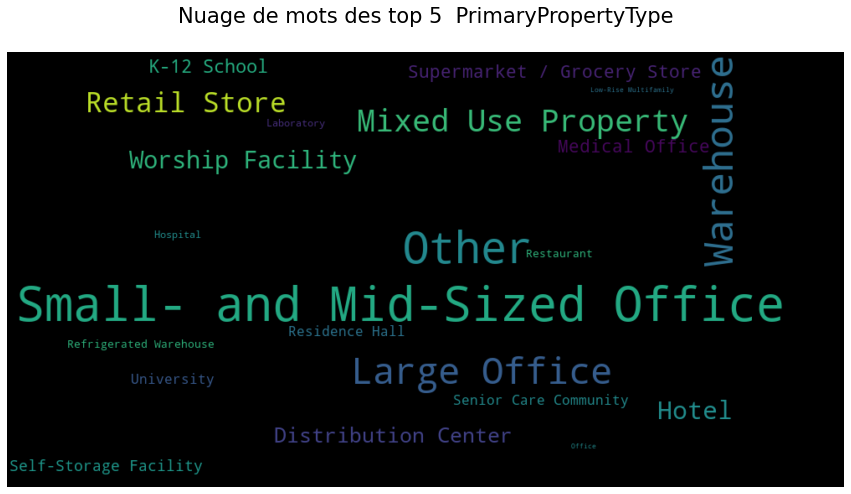

In [230]:
trace_word(df=data1,column="PrimaryPropertyType",nb_top=5)

5% des bâtiments qui ont la plus grande surface.

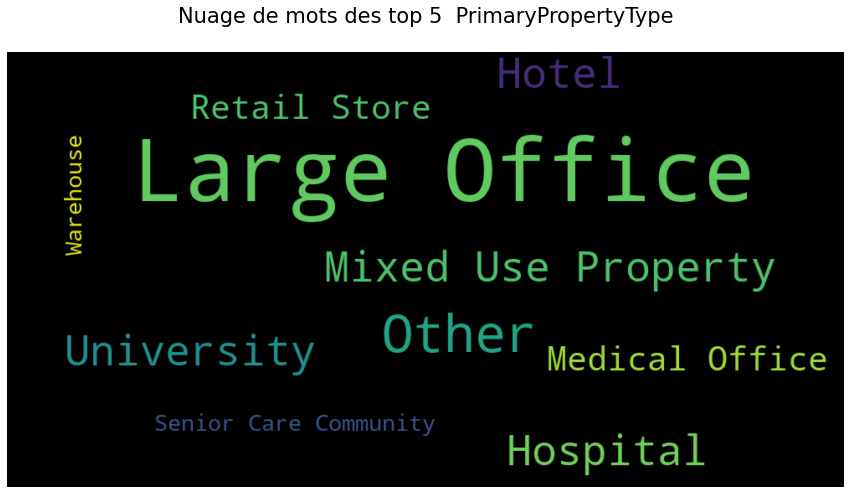

In [231]:
trace_word(df=data1[ data1["PropertyGFATotal"]> data1["PropertyGFATotal"].quantile(.95)],column="PrimaryPropertyType",nb_top=5)

In [232]:
data1["SecondLargestPropertyUseType"].fillna ("Other", inplace =True)
data1["Outlier"].fillna("inconnue", inplace =True)
data1["LargestPropertyUseType"].fillna ("Other", inplace =True)
#On garde que les bâtiments qui ne sont pas Outliers et dont le statut est conforme.
data1 = data1[(data1['Outlier']=='inconnue') | (data1['ComplianceStatus']=='Compliant' ) ]

#### Imputation des valeurs manquantes 

In [233]:
col1 = [ "OSEBuildingID",	"BuildingType",	"PrimaryPropertyType"	,"Address", "PropertyGFATotal", "NumberofBuildings","SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","SteamUse(kBtu)"]

In [234]:
data1[ data1["SiteEnergyUse(kBtu)"].isnull()] [col1]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,PropertyGFATotal,NumberofBuildings,SiteEnergyUse(kBtu),NaturalGas(kBtu),Electricity(kBtu),SteamUse(kBtu)


In [235]:
data1.isnull().sum()

OSEBuildingID                     0
BuildingType                      0
PrimaryPropertyType               0
Address                           0
City                              0
State                             0
ZipCode                          16
Latitude                          0
Longitude                         0
DataYear                          0
YearBuilt                         0
NumberofBuildings                 0
NumberofFloors                    0
PropertyGFATotal                  0
SiteEUI(kBtu/sf)                  0
PropertyGFAParking                0
SiteEUIWN(kBtu/sf)                0
SiteEnergyUseWN(kBtu)             0
LargestPropertyUseType            0
SecondLargestPropertyUseType      0
ENERGYSTARScore                 534
ComplianceStatus                  0
Outlier                           0
TotalGHGEmissions                 0
GHGEmissionsIntensity             0
SiteEnergyUse(kBtu)               0
SteamUse(kBtu)                    0
NaturalGas(kBtu)            

- La seule variable à imputer est *ENERSTARScore*. Obeservons d'abord sa distribution



In [236]:
data_bf_imp = data1.copy()

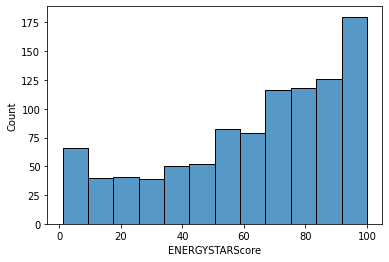

In [237]:
#fig = px.histogram(data1, x="ENERGYSTARScore", width=700, height=500)
#fig.show()
sns.histplot(data=data1, x="ENERGYSTARScore")

Avant d'imputer je crée une colonne contenant les étiquettes pour chaque bâtiment dont l'"ENERGYSTARScore"  est manquant.

In [238]:
data1['is_energyStarImputed'] = np.where (data1["ENERGYSTARScore"].isnull(), True, False)

In [239]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

# Entrainenement du modèle d'imputation sur un échantillon
knn_features = ["NumberofBuildings",'NumberofFloors',"SiteEnergyUse(kBtu)","TotalGHGEmissions",  'PropertyGFATotal', "SiteEnergyUseWN(kBtu)","ENERGYSTARScore","PropertyGFABuilding(s)"]
sample_datas = data1[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)




KNNImputer()

In [240]:
data1[knn_features]

,NumberofBuildings,NumberofFloors,SiteEnergyUse(kBtu),TotalGHGEmissions,PropertyGFATotal,SiteEnergyUseWN(kBtu),ENERGYSTARScore,PropertyGFABuilding(s)
0,1.0,12,7.226362e+06,249.98,88434,7.456910e+06,60.0,88434
1,1.0,11,8.387933e+06,295.86,103566,8.664479e+06,61.0,88502
2,1.0,41,7.258702e+07,2089.28,956110,7.393711e+07,43.0,759392
3,1.0,10,6.794584e+06,286.43,61320,6.946800e+06,56.0,61320
4,1.0,18,1.417261e+07,505.01,175580,1.465650e+07,75.0,113580
...,...,...,...,...,...,...,...,...
3371,1.0,1,8.497457e+05,20.94,12294,9.430032e+05,46.0,12294
3372,1.0,1,9.502762e+05,32.17,16000,1.053706e+06,NaN,16000
3373,1.0,1,5.765898e+06,223.54,13157,6.053764e+06,NaN,13157
3374,1.0,1,7.194712e+05,22.11,14101,7.828413e+05,NaN,14101


In [241]:
# Application du modèle sur l'ensemble des données
datas_imputed = imputer.transform(data1[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)
data1["ENERGYSTARScore"] = df_datas_imputed["ENERGYSTARScore"].values

- Comparaison de la distribution de la variable Energystar score avant et après imputation.

In [242]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2)

trace0 = go.Histogram(x=data_bf_imp["ENERGYSTARScore"], name ="ENERGYSTARScore")
trace1 = go.Histogram(x=data1["ENERGYSTARScore"], name = "Knn_imputed")

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)


fig.show()

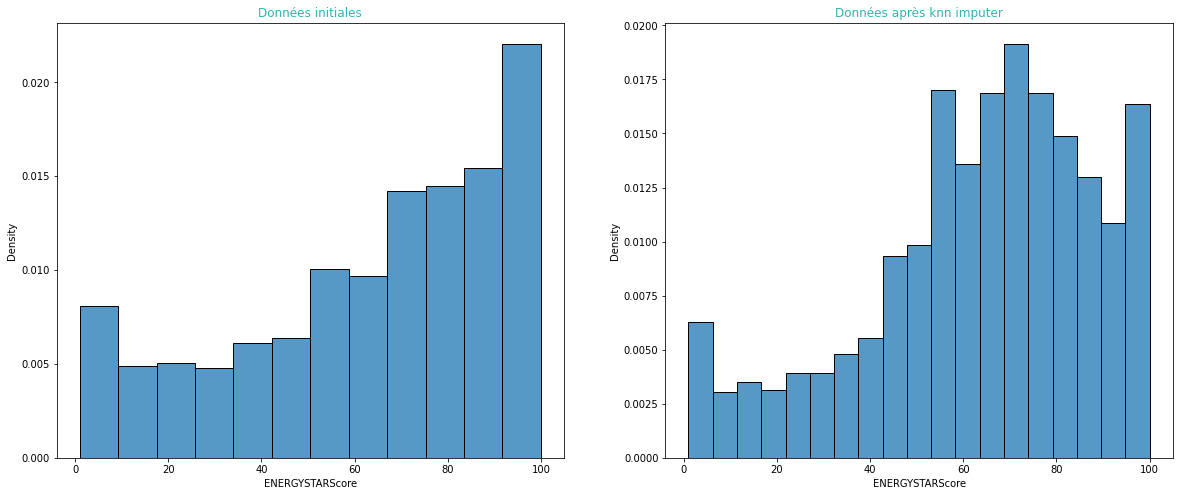

In [243]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=data_bf_imp, x="ENERGYSTARScore", stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=data1, x="ENERGYSTARScore", stat="density", ax=axes[1])
axes[1].set_title("Données après knn imputer", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

Faire un test statisque ou KNN regressor 

- Boxplot des deux distributions

In [244]:
fig = go.Figure()
fig.add_trace(go.Box(y=data1["ENERGYSTARScore"]))
fig.add_trace(go.Box(y=data_bf_imp["ENERGYSTARScore"], name="Knn_imputed"))
fig.show()

In [245]:
list_address =data1[data1["ZipCode"].isnull() ] ["Address"].to_list()

- Imputation du Zipcode 

In [246]:
data1["ZipCode"].isnull().sum()

16

In [247]:
data1.isnull().sum()

OSEBuildingID                    0
BuildingType                     0
PrimaryPropertyType              0
Address                          0
City                             0
State                            0
ZipCode                         16
Latitude                         0
Longitude                        0
DataYear                         0
YearBuilt                        0
NumberofBuildings                0
NumberofFloors                   0
PropertyGFATotal                 0
SiteEUI(kBtu/sf)                 0
PropertyGFAParking               0
SiteEUIWN(kBtu/sf)               0
SiteEnergyUseWN(kBtu)            0
LargestPropertyUseType           0
SecondLargestPropertyUseType     0
ENERGYSTARScore                  0
ComplianceStatus                 0
Outlier                          0
TotalGHGEmissions                0
GHGEmissionsIntensity            0
SiteEnergyUse(kBtu)              0
SteamUse(kBtu)                   0
NaturalGas(kBtu)                 0
Electricity(kBtu)   

In [248]:
data1.isnull().sum()

OSEBuildingID                    0
BuildingType                     0
PrimaryPropertyType              0
Address                          0
City                             0
State                            0
ZipCode                         16
Latitude                         0
Longitude                        0
DataYear                         0
YearBuilt                        0
NumberofBuildings                0
NumberofFloors                   0
PropertyGFATotal                 0
SiteEUI(kBtu/sf)                 0
PropertyGFAParking               0
SiteEUIWN(kBtu/sf)               0
SiteEnergyUseWN(kBtu)            0
LargestPropertyUseType           0
SecondLargestPropertyUseType     0
ENERGYSTARScore                  0
ComplianceStatus                 0
Outlier                          0
TotalGHGEmissions                0
GHGEmissionsIntensity            0
SiteEnergyUse(kBtu)              0
SteamUse(kBtu)                   0
NaturalGas(kBtu)                 0
Electricity(kBtu)   

In [249]:
data1 =data1[data1["BuildingType"]!='Nonresidential WA']

In [250]:
data1["BuildingType"].value_counts()

NonResidential        1424
Nonresidential COS      75
Campus                  23
Name: BuildingType, dtype: int64

### Analyse exploratoire 

- Boxplot des variables quantitatives 

In [251]:
#Calcul de l'âge du bâtiment en 2016
data1["age_batiment"] = 2016-data1["YearBuilt"]

#Choix des variables numériques
var_numeriques=list(data1.select_dtypes(include=["float64","int64"]).columns) 
var_numeriques= var_numeriques [-(len(var_numeriques)-5):]
var_numeriques

fig = go.Figure()
for variable in var_numeriques :
  fig.add_trace(go.Box(y=data1[variable], name=variable))
fig.show()

<ipython-input-251-fcab9c91d309>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Le graphique montre que certaines variables contiennent potentiellement des valeurs qui sont soit abberantes soit atypiques.

On voit que les variables *SiteEnergyUse(kBtu)*, *SiteEnergyUseWN(kBtu)*, *SteamUse(kBtu)*, *Electricity(kBh)*, et *NaturalGas(kBtu)* ont des valeurs qui semblent être soit abberantes ou soit atypiques. Affinons l'analyse des ces valeurs pour réellement savoir si elles sont réllement abberantes. 

Etant donné que  *SiteEnergyUse(kBtu)* = *SteamUse(kBtu)* + *Electricity(kBh)* + *NaturalGas(kBtu)*, il ne serait pas surprenant  de voir que les batiments détenant des valeurs abberantes pour une variable donnée soient identiques à ceux détenant des abberantes/atypiques pour les autres.

Nous allons extraire les bâtiments ayant des valeurs abberantes/atypiques pour chacune des variables mentionnées plus haut. Nous aurons ainsi 4 groupes de bâtiments que nous allons comparer pour voir si ils sont indentiques.

L'objectif étant de vérifier que le groupe de bâtiments ayant des valeurs abberantes/atypiques pour la variable *SiteEnergyUse(kBtu)* est similaire aux groupes ayant des valeurs abberantes/atypiques pour *SteamUse(kBtu)* , *Electricity(kBh)* et *NaturalGas(kBtu)*.



In [252]:
x=data1[ data1["SiteEnergyUse(kBtu)"] > data1["SiteEnergyUse(kBtu)"].quantile(0.98)]

#Bâtiment à valeur abberantes pour la variable SiteEnergyUse(kBtu)
x1=data1[ data1["SiteEnergyUse(kBtu)"] > data1["SiteEnergyUse(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable NaturalGas(kBtu)
x2=data1[ data1["NaturalGas(kBtu)"] > data1["NaturalGas(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable SteamUse(kBtu)
x3=data1[ data1["SteamUse(kBtu)"] > data1["SteamUse(kBtu)"].quantile(0.98)]["OSEBuildingID"]

#Bâtiment à valeur abberantes pour la variable  Electricity(kBtu)
x4=data1[ data1["Electricity(kBtu)"] > data1["Electricity(kBtu)"].quantile(0.98)]["OSEBuildingID"]

In [253]:
print (len(set(x1).intersection(set(x3)))/ len(x3) )

0.1935483870967742


19% des valeurs abberantes/atypiques des variables "SiteEnergyUse(kBtu) et NaturalGas(kBtu)  

In [254]:
print (len(set(x2).intersection(set(x1))) /len(x2)  )

0.4838709677419355


48,3% des valeurs abberantes/atypiques des variables "NaturalGas(kBtu) sont atypiques/abberantes pour SiteEneergyUse(kBtu)  

In [255]:
print (len(set(x1).intersection(set(x1))) /len(x4)  )

1.0


In [256]:
print (len(set(x3).intersection(set(x4)))/ len(x3) )

0.16129032258064516


- Energy star score 

Quelques bâtiments ayant un energystarScore inférieur à 8. Observons ça de plus près.

In [257]:
col3  =  ["OSEBuildingID","BuildingType", "PrimaryPropertyType","YearBuilt", "NumberofBuildings" , "NumberofFloors", "PropertyGFATotal"
              ,"SiteEnergyUseWN(kBtu)", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ENERGYSTARScore","TotalGHGEmissions","SiteEnergyUse(kBtu)"]

data1[data1["ENERGYSTARScore"]<=8][col3] 

,OSEBuildingID,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse(kBtu)
35,43,Campus,Mixed Use Property,1992,1.0,3,494835,4.716139e+08,Office,Laboratory,8.0,16870.98,4.483853e+08
60,85,NonResidential,Senior Care Community,1970,1.0,2,93397,1.695975e+07,Senior Care Community,Other,1.0,609.10,1.640256e+07
193,313,NonResidential,Medical Office,1927,1.0,5,190000,2.873150e+07,Medical Office,Office,1.0,661.04,2.873150e+07
194,314,NonResidential,Hotel,1961,1.0,4,122309,2.612202e+07,Hotel,Other,8.0,1060.13,2.545369e+07
253,379,NonResidential,Large Office,1984,1.0,8,253103,2.994925e+07,Office,Parking,3.0,208.79,2.994925e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,27142,NonResidential,K-12 School,1912,1.0,4,27800,1.275996e+06,K-12 School,Other,8.0,38.36,1.181429e+06
2930,27567,NonResidential,Small- and Mid-Sized Office,1995,1.0,3,20410,2.827857e+06,Office,Other,8.0,77.84,2.720238e+06
3060,28025,Nonresidential COS,Warehouse,1967,1.0,2,22058,2.235498e+06,Non-Refrigerated Warehouse,Office,1.0,66.43,1.987335e+06
3065,28033,NonResidential,Distribution Center,1971,1.0,1,28320,4.403066e+06,Distribution Center,Parking,1.0,67.96,4.236396e+06


64 bâtiments qui ont une ENRGYSTARScore très basse.

In [258]:
low_EnergyStar = data1[data1["ENERGYSTARScore"]<=8][col3] 
low_EnergyStar["OSEBuildingID"] = low_EnergyStar["OSEBuildingID"].apply(str)

In [259]:
surface_median =data1["PropertyGFATotal"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="PropertyGFATotal"), x='PropertyGFATotal', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=surface_median, y0=0, x1=surface_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

In [260]:
energy_median = data1["SiteEnergyUse(kBtu)"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="SiteEnergyUse(kBtu)"), x='SiteEnergyUse(kBtu)', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=energy_median, y0=0, x1=energy_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

In [261]:
nbFloor_median = data1["NumberofFloors"].median()
fig = px.histogram(low_EnergyStar.sort_values(by="NumberofFloors"), x='NumberofFloors', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=nbFloor_median, y0=0, x1=nbFloor_median,y1=64,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On remarque que les bâtiments qui ont une energystarSCore Basse ont en général une consommation d'enérgie plus supérieure à la consommation d'énérgie médiane, 35% d'entre eux ont une surface plus grande que la surface médiane et 65,5% ont un NumberofFloor supérieur ou égal à 2.

-  Emission de carbone

In [262]:
fig = px.box(data1, y="TotalGHGEmissions")
fig.show()

Observons le boxplot sans les valeurs atypiques

In [263]:
fig = px.box(data1[data1["TotalGHGEmissions"]<data1["TotalGHGEmissions"].quantile(0.80)], y="TotalGHGEmissions")
fig.show()

Quels sont les bâtiments qui ont ces valeurs atypiques 

In [264]:
x_sup=data1[data1["TotalGHGEmissions"]>data1["TotalGHGEmissions"].quantile(0.80)]
x_inf=data1[data1["TotalGHGEmissions"]<data1["TotalGHGEmissions"].quantile(0.80)]

Ces bâtiments sont-ils les bâtiments qui ont la plus grande surface ? la plus consomation d'énergie ? Quel est l'usage dont on fait de ces batiments ? 

In [265]:
data1.columns.to_list()

['OSEBuildingID',
 'BuildingType',
 'PrimaryPropertyType',
 'Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'DataYear',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ENERGYSTARScore',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'is_true_EnergyUse_Sum',
 'Ecart_energyUse_sumEnergy',
 'SiteEUI_calculated',
 'is_true_EUIcalculated_eq_EUI',
 'is_energyStarImputed',
 'age_batiment']

In [266]:
x_sup_hist=x_sup.groupby("PrimaryPropertyType").agg({'OSEBuildingID': 'count', 'PropertyGFATotal': 'mean', 'SiteEnergyUse(kBtu)':'mean'}).reset_index()[["PrimaryPropertyType","OSEBuildingID","PropertyGFATotal","SiteEnergyUse(kBtu)"]]
fig = px.bar(x_sup_hist.sort_values(by="OSEBuildingID"), x="OSEBuildingID", y="PrimaryPropertyType").update_xaxes(categoryorder='total descending')
fig.show()

Les valeurs en emssions de carbone atypiques concernenent les supermarchés, Hotels, Large Office

In [267]:
x_sup_hist1=x_sup.groupby("LargestPropertyUseType").agg({'OSEBuildingID': 'count', 'PropertyGFATotal': 'mean'}).reset_index()[["LargestPropertyUseType","OSEBuildingID","PropertyGFATotal"]]
fig = px.histogram(x_sup_hist1.sort_values(by="OSEBuildingID"), x='OSEBuildingID', y='LargestPropertyUseType', text_auto=True)
fig.show()

In [268]:
x_sup1 = x_sup.copy()
x_sup1["OSEBuildingID"] = x_sup1["OSEBuildingID"].apply(str)

In [269]:
surface_median =data1["PropertyGFATotal"].median()
fig = px.histogram(x_sup1.sort_values(by="PropertyGFATotal"), x='PropertyGFATotal', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=surface_median, y0=0, x1=surface_median,y1=305,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On voit que ces bâtiments ont pour la plupart une surface  supérieure à la surface médiane.

In [270]:
energy_median = data1["SiteEnergyUse(kBtu)"].median()
fig = px.histogram(x_sup1.sort_values(by="SiteEnergyUse(kBtu)"), x='SiteEnergyUse(kBtu)', y='OSEBuildingID', text_auto=True)
fig.add_shape(type='line', x0=energy_median, y0=0, x1=energy_median,y1=305,line=dict(color='Red',),xref='x',yref='y')
fig.show()

On voit que ces bâtiments ont pour la plupart une consommation d'énérgie  supérieure à la consommation d'énérgie médiane.

Donc on peut conclure que ces valeurs sont bien des valeurs atypiques. 

- Correlation entre le PropertyPrimaryType et la Surface ?

In [271]:
data1["count"] =1

Répartion des bâtiments selon l'année de construction

In [272]:
fig = px.histogram(data1, x='YearBuilt', text_auto=True)
fig.show()

Y-a-t'il une influence entre le LargestPropertyUse et l'emissionen carbonne. 

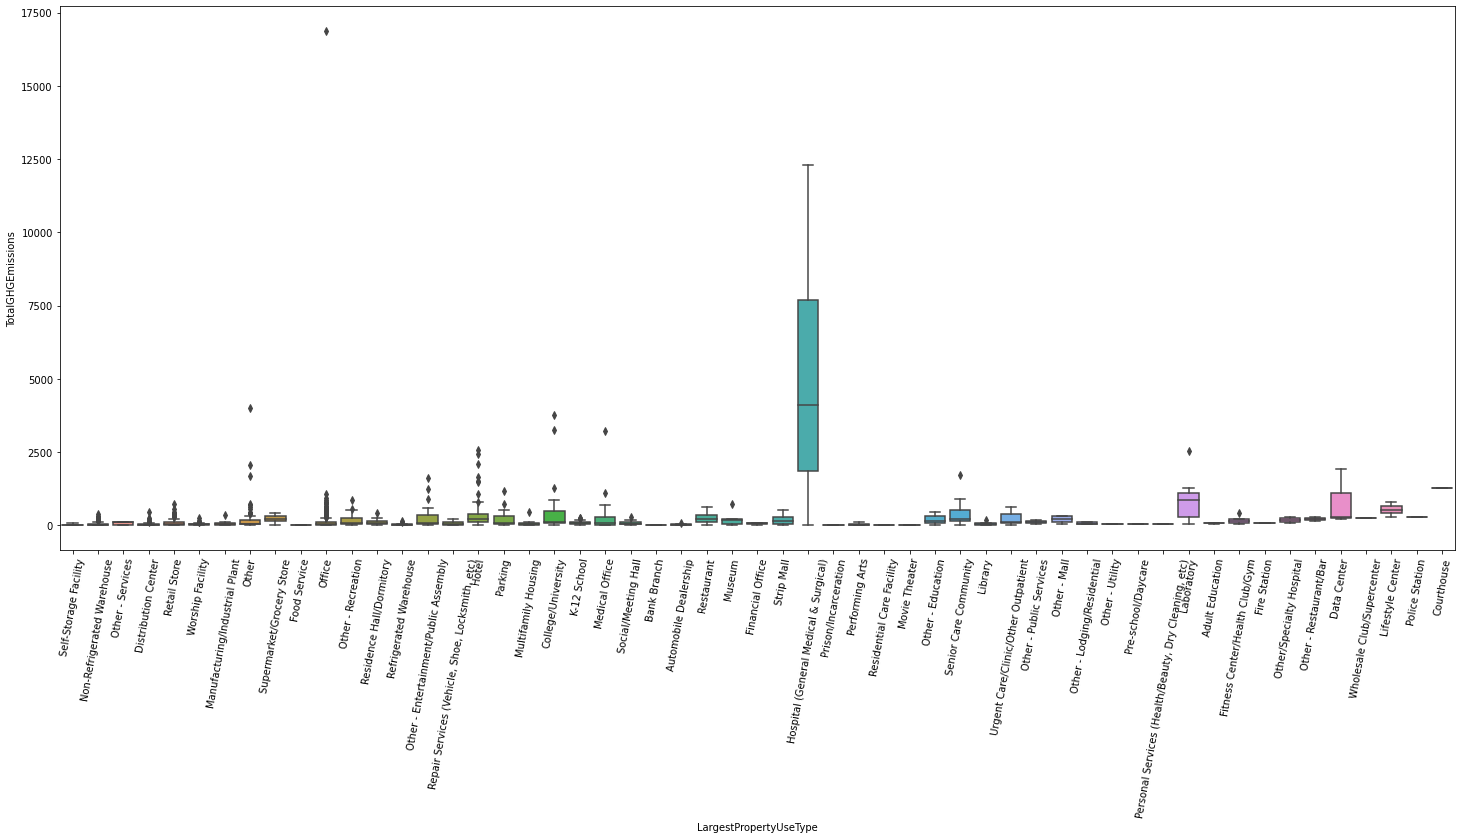

In [273]:
f, ax = plt.subplots(figsize=(25, 10))
sns.boxplot(x="LargestPropertyUseType", y="TotalGHGEmissions", data=data1.sort_values (by="TotalGHGEmissions"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
plt.show()

Anova  entre  TotalGHGEmissions~ C(LargestPropertyUseType)

In [274]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
model = ols('TotalGHGEmissions~ C(LargestPropertyUseType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(LargestPropertyUseType),2.636462e+08,54.0,12.99009,7.913025e-90
Residual,5.513733e+08,1467.0,NaN,NaN


La p-value est inférieure à 0.05. Donc on rejette l'hypothèse nulle. On peut donc affirmer que le LargestPropertyUse a bien un impact sur l'emission de carbone.

Nous allons tout de même vérifier que les hypothèses du modèles anaova sont resepctées. Mêmes si les hyptothèses du modèles ne sont pas toutes vérifiées, notre modèle restera valable vu que ANOVA n'exige qu'un respect approximatif des conditions.

In [275]:
from statsmodels.stats.stattools import durbin_watson
#perform Durbin-Watson test
durbin_watson(model.resid)

#H0 : Les résidus sont indépendantes

1.9491204541665905

In [276]:
from scipy import stats
#Evaluation de l'hypothèse de normalité des résidus
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)
#H0:  Le données suivent une loi normale

0.239768385887146 0.0


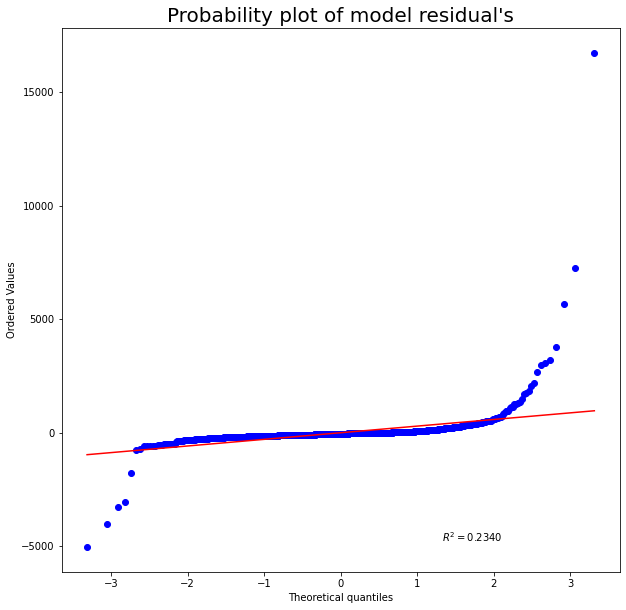

In [277]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [278]:
#Création des pivot tabble pour le test de Bartlett
food_data_pivot=data1[['OSEBuildingID','LargestPropertyUseType','TotalGHGEmissions']].pivot(index=['OSEBuildingID'],columns="LargestPropertyUseType", values="TotalGHGEmissions")
food_data_pivot

LargestPropertyUseType,Adult Education,Automobile Dealership,Bank Branch,College/University,Courthouse,Data Center,Distribution Center,Financial Office,Fire Station,Fitness Center/Health Club/Gym,...,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [279]:
#food_data_pivot=food_data_pivot.fillna(0)
#w, pvalue = stats.bartlett(food_data_pivot['a'], food_data_pivot['b'],food_data_pivot['c'], food_data_pivot['d'],food_data_pivot['e'])
#print(w, pvalue)
#H0 : La variances sont identiques (homogénité)

In [280]:
Eta_squared=2.634213e+08 /(2.634213e+08+5.520820e+08)
print("Intensité de l'impact :",Eta_squared)

Intensité de l'impact : 0.3230168412561911


Corrélation entre EnergyStarScore et LargestPropertyUse

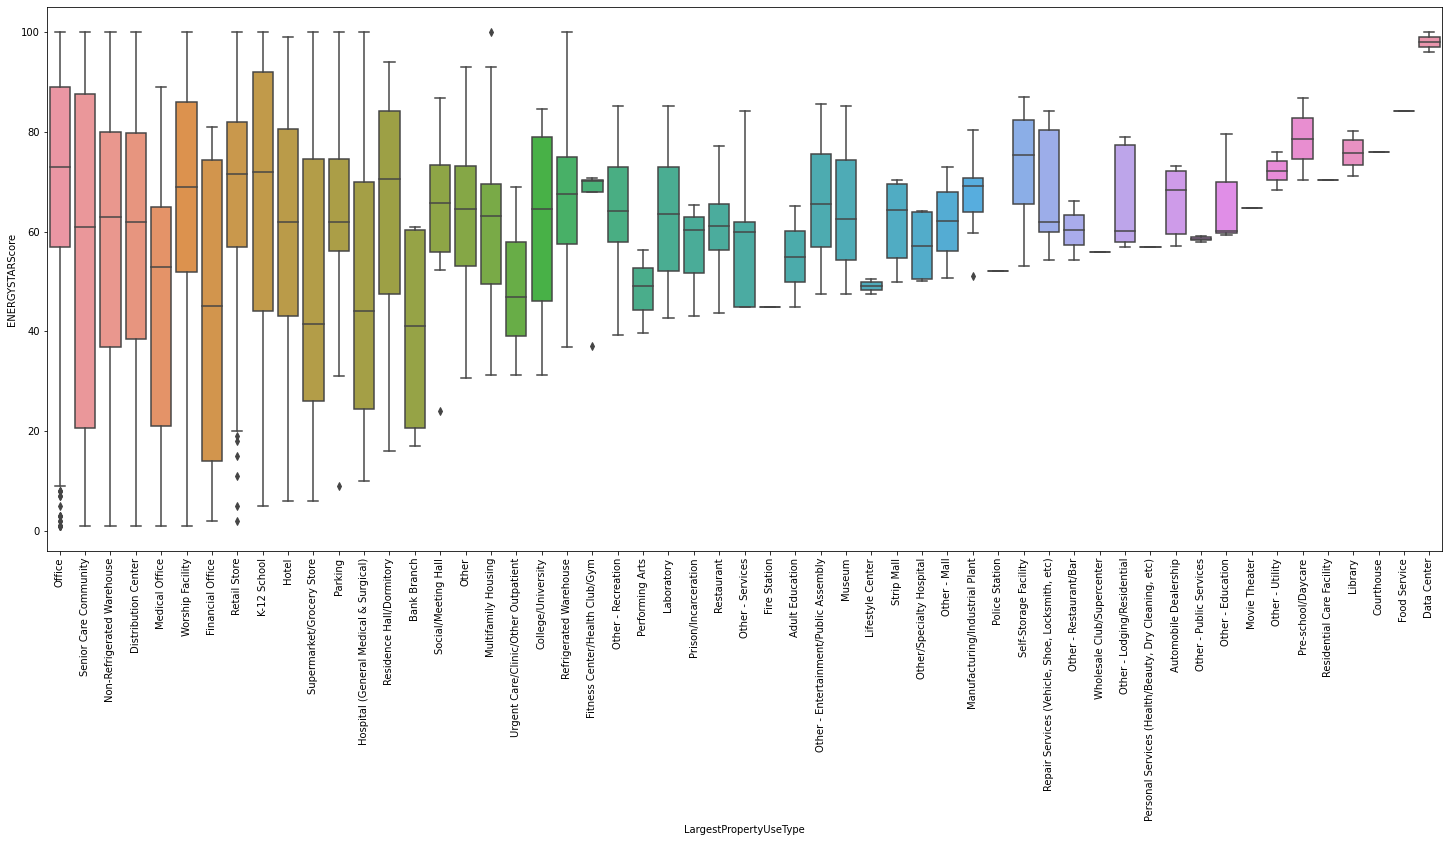

In [281]:
f, ax = plt.subplots(figsize=(25, 10))
sns.boxplot(x="LargestPropertyUseType", y="ENERGYSTARScore", data=data1.sort_values (by="ENERGYSTARScore"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [282]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
model = ols('ENERGYSTARScore~ C(LargestPropertyUseType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(LargestPropertyUseType),70354.314762,54.0,2.282295,5.677020e-07
Residual,837443.026420,1467.0,NaN,NaN


Corrélation entre TotalGhGemission et PrimaryPropertyType

In [283]:
# Ordinary Least Squares (OLS) model
model = ols('TotalGHGEmissions~ C(PrimaryPropertyType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(PrimaryPropertyType),2.650366e+08,21.0,34.4214,3.550096e-112
Residual,5.499830e+08,1500.0,NaN,NaN


Corrélation entre  ENERGYSTARScore et PrimaryPropertyType

In [284]:
# Ordinary Least Squares (OLS) model
model = ols('ENERGYSTARScore~ C(PrimaryPropertyType)', data=data1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(PrimaryPropertyType),72943.200964,21.0,6.240885,4.654636e-17
Residual,834854.140219,1500.0,NaN,NaN


La p value confirme que nous pouvons rejeter l'indépendance de la variable SiteEnergyUseWN(kBtu) vis à vis des modalités de la variable PrimaryPropertyType.

## On va créer de nouvelles variables afin d'améliorer notre feature engenireeng
---

In [285]:
#On calcule les ratios
data1['Ratio_buildingParSurface'] =round(data['PropertyGFABuilding(s)']/data['PropertyGFATotal'],2)   #proportion de bâtiment par surfarce

data1['Ratio_parkingParSurface'] = round(data['PropertyGFAParking']/data['PropertyGFATotal'],5)*100   #--


data1['SurfaceParBatiment'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),5)

data1['SurfaceParetage'] = round(data['PropertyGFATotal'] / (data['NumberofFloors']+1),5)

In [286]:
data1['pr_steam'] = data1['SteamUse(kBtu)']/data1['SiteEnergyUse(kBtu)']  #proportion de steam
data1['pr_natural'] = data1['NaturalGas(kBtu)']/data1['SiteEnergyUse(kBtu)'] #proportion de gaz naturel
data1['pr_elec'] = data1['Electricity(kBtu)']/data1['SiteEnergyUse(kBtu)'] #proportion d'éléctricité

In [287]:
data1[data1["NumberofFloors"]==0]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,City,State,ZipCode,Latitude,Longitude,DataYear,...,is_energyStarImputed,age_batiment,count,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParBatiment,SurfaceParetage,pr_steam,pr_natural,pr_elec
166,267,NonResidential,Hotel,721 Pine St,Seattle,WA,98101.0,47.61275,-122.33330,2016,...,True,17,1,1.0,0.0,934292.00,934292.0,0.000000,0.394838,0.605162
487,656,NonResidential,Medical Office,1221 Madison Street,Seattle,WA,98104.0,47.60979,-122.32298,2016,...,False,12,1,1.0,0.0,225982.00,225982.0,0.380128,0.000000,0.619872
488,657,NonResidential,Mixed Use Property,2200 Westlake Ave.,Seattle,WA,98121.0,47.61783,-122.33729,2016,...,False,10,1,1.0,0.0,inf,516407.0,0.000000,0.253037,0.746963
564,758,NonResidential,Other,600 Pine Street,Seattle,WA,98101.0,47.61289,-122.33531,2016,...,True,17,1,1.0,0.0,947987.00,947987.0,0.000000,0.000000,1.000000
1754,23311,NonResidential,Medical Office,1124 Columbia Street,Seattle,WA,98104.0,47.60862,-122.32372,2016,...,False,71,1,1.0,0.0,274568.00,274568.0,0.525304,0.000000,0.474696
1993,24086,Campus,Other,1333 AIRPORT WAY S,Seattle,WA,98134.0,47.59042,-122.32498,2016,...,True,25,1,1.0,0.0,23097.10,230971.0,0.000000,0.266504,0.733496
3130,40028,NonResidential,Warehouse,7561 63rd Ave NE,Seattle,WA,98115.0,47.68454,-122.26235,2016,...,False,76,1,1.0,0.0,384772.00,384772.0,0.000000,0.407180,0.592820
3131,40031,NonResidential,Medical Office,6222 NE 74th St,Seattle,WA,98115.0,47.68240,-122.26223,2016,...,False,56,1,1.0,0.0,30287.00,30287.0,0.000000,0.172225,0.827775
3132,40034,NonResidential,Small- and Mid-Sized Office,6200 NE 74th ST,Seattle,WA,98115.0,47.68254,-122.26299,2016,...,False,56,1,1.0,0.0,21931.00,21931.0,0.000000,0.645676,0.354324
3168,49705,Nonresidential COS,Other,7400 Sand Point Way NE,Seattle,WA,98115.0,47.68212,-122.26330,2016,...,True,87,1,1.0,0.0,62753.75,502030.0,0.000000,0.493248,0.506752


In [288]:
#data1.replace([np.inf, -np.inf], 0, inplace=True)

In [289]:
var_numeriques

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'PropertyGFAParking',
 'SiteEUIWN(kBtu/sf)',
 'SiteEnergyUseWN(kBtu)',
 'ENERGYSTARScore',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'PropertyGFABuilding(s)',
 'Ecart_energyUse_sumEnergy',
 'SiteEUI_calculated',
 'age_batiment']

On conserve que ces variables pour la suite de l'étude.

In [290]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'SiteEUI_calculated',
 'PropertyGFAParking',
 'ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)',
 'age_batiment',
 'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
 'SurfaceParetage'
 ]]

Certains bâtiments ont une consommation d'énérgie non renseignée.

In [291]:
data1[data1['pr_elec'].isnull()] [['BuildingType',	'PrimaryPropertyType','SiteEnergyUse(kBtu)','TotalGHGEmissions',  'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'Electricity(kBtu)']]

,BuildingType,PrimaryPropertyType,SiteEnergyUse(kBtu),TotalGHGEmissions,SteamUse(kBtu),NaturalGas(kBtu),Electricity(kBtu)


In [292]:
#data1= data1[ data1['SiteEnergyUse(kBtu)']!= 0]
#data1=data1.dropna(axis=0)
data1[data1['pr_elec'].isnull()] [['BuildingType',	'PrimaryPropertyType','SiteEnergyUseWN(kBtu)','TotalGHGEmissions']]

,BuildingType,PrimaryPropertyType,SiteEnergyUseWN(kBtu),TotalGHGEmissions


In [293]:
data_model ['Ratio_buildingParSurface'].describe()

count    1522.000000
mean        0.934507
std         0.143663
min         0.100000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Ratio_buildingParSurface, dtype: float64

## Corrélation  des variables numériques 
---

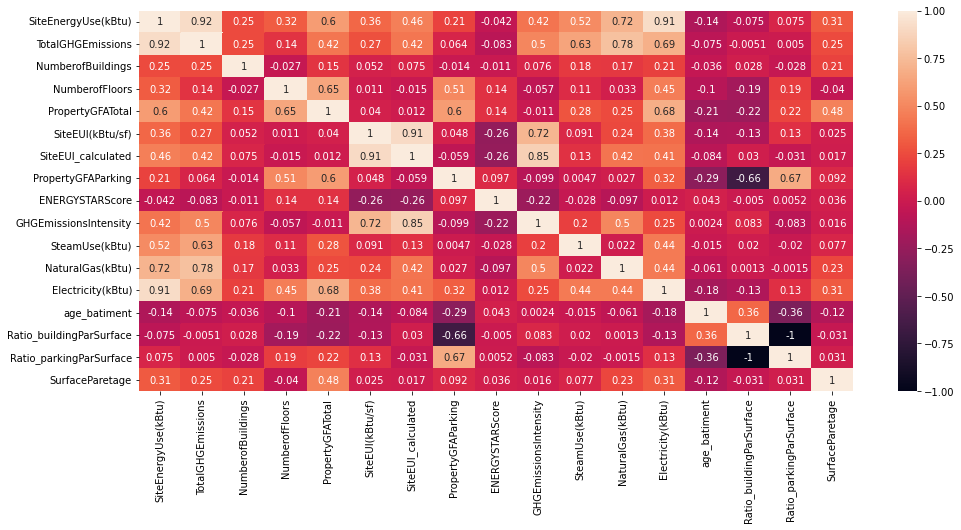

In [294]:
matrix = data_model.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 7))
sns.heatmap(matrix,vmin=-1, vmax=1, annot=True)

Nous remarquons que certaines variables ont une forte corrélation linéaire. Et cela peut susciter une colinéarité entre certaines variables, ce qui n'est pas très bon pour nos modèles de regression, car multicolinéarité.

Nous savons que SiteEnergyUse (Kbtu) = SteamUse(kBtu) + NaturalGas(kBtu) + Electricity (kBtu). Il y a donc une colinéarité entre ces 4 variables. Nous allons donc supprimer les 3 variables situées à droite de l'égalité dans nos modèles.

In [295]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
  'PropertyGFAParking',
 'SiteEUI(kBtu/sf)',
 'ENERGYSTARScore',
 'age_batiment',
 'Ratio_parkingParSurface',
 'SurfaceParetage',
 'pr_steam',
 'pr_natural',
 'pr_elec'
 ]]


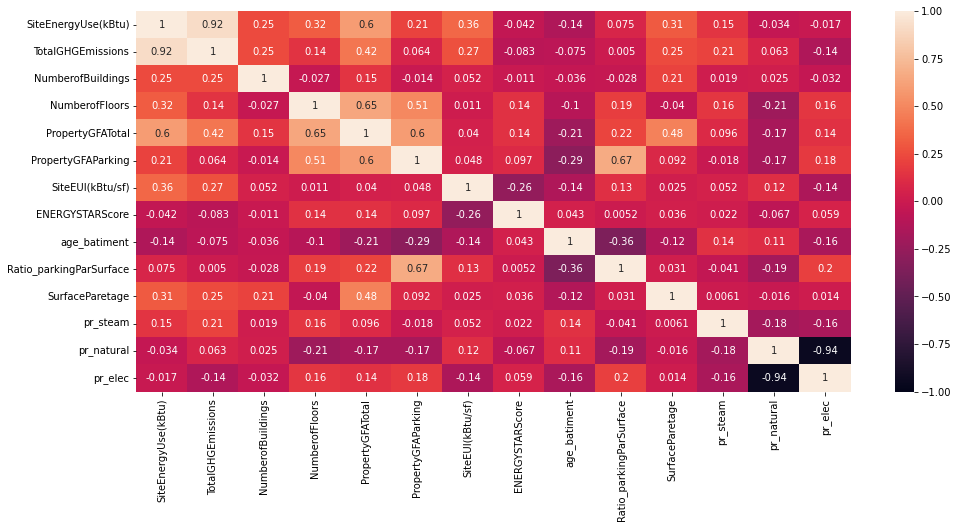

In [296]:
matrix = data_model.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 7))
sns.heatmap(matrix,vmin=-1, vmax=1, annot=True)

Nos deux variables à prédire sont formtement coréllées. 
On nolte aussi une corrélation modérée entre NumberofFlorrs et PropertyGFAtOTAL , entre SiteEnergyUse(kbtu) et PropertyGFATotal.   Il faut savoir que lorsqu’on fait une régression linéaire on pose certaines hypothèses notamment la Non-colinéarité des variables explicatives (une variable explicative ne doit pas pouvoir s’écrire comme combinaison linéaire des autres). Après une analyse minutieuse nous choisissons les variables 

Nous allons vérifier la multicolinéarité des variables à l'aide du VIF 

In [297]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = data_model

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)


                    feature        VIF
0       SiteEnergyUse(kBtu)  15.324358
1         TotalGHGEmissions  10.342214
2         NumberofBuildings   1.102350
3            NumberofFloors   2.658789
4          PropertyGFATotal   5.582574
5        PropertyGFAParking   3.458352
6          SiteEUI(kBtu/sf)   1.545316
7           ENERGYSTARScore   1.119944
8              age_batiment   1.229852
9   Ratio_parkingParSurface   2.238476
10          SurfaceParetage   1.922746
11                 pr_steam   1.496040
12               pr_natural   4.061796
13                  pr_elec   9.896675


Nos deux variables à variables à prédire ont un vif supérieure à 10. Pour les autres variables rien d'alarmant. On peut donc conserver  les 3 variables qui ont un vif supérieures à 5 surtout pour nos modèles nos linéaires. 

In [298]:
data1.dtypes

OSEBuildingID                     int64
BuildingType                     object
PrimaryPropertyType              object
Address                          object
City                             object
State                            object
ZipCode                         float64
Latitude                        float64
Longitude                       float64
DataYear                          int64
YearBuilt                         int64
NumberofBuildings               float64
NumberofFloors                    int64
PropertyGFATotal                  int64
SiteEUI(kBtu/sf)                float64
PropertyGFAParking                int64
SiteEUIWN(kBtu/sf)              float64
SiteEnergyUseWN(kBtu)           float64
LargestPropertyUseType           object
SecondLargestPropertyUseType     object
ENERGYSTARScore                 float64
ComplianceStatus                 object
Outlier                          object
TotalGHGEmissions               float64
GHGEmissionsIntensity           float64


In [299]:
data_model = data1[[
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 "PropertyGFABuilding(s)",
 'ENERGYSTARScore',
 'age_batiment',
 'LargestPropertyUseType',
 'PrimaryPropertyType',
 "BuildingType",
 'Ratio_buildingParSurface',
 'Ratio_parkingParSurface',
  'SurfaceParetage',
  "ComplianceStatus", 
  "Outlier",
  'is_energyStarImputed',
  'pr_steam',
 'pr_natural',
 'pr_elec'
 ]].copy()

Nous allons utilisé oneHotenconder afin d'encoder les variables catégorielles. Nous allons cependant exclure les catégories les moins représentées afin de limiter le nombre de variables dans notre modèle. 

In [300]:
ppt=pd.DataFrame(data_model['PrimaryPropertyType'].value_counts())
ppt

,PrimaryPropertyType
Small- and Mid-Sized Office,284
Other,232
Warehouse,187
Large Office,165
Mixed Use Property,112
Retail Store,88
Hotel,75
Worship Facility,69
Distribution Center,53
K-12 School,41


In [301]:
# ['Fire Station', 'Lifestyle Center', 'Other - Utility', 'Adult Education', 'Movie Theater', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Other - Restaurant/Bar']l
lpt=pd.DataFrame(data_model ['LargestPropertyUseType'].value_counts() )
lpt
data_model ['LargestPropertyUseType'].value_counts().mean()

27.672727272727272

In [302]:
"""l1=ppt[ppt.values<ppt.values.mean()].index.to_list()"""
"""l2=lpt[lpt.values<lpt.values.mean()].index.to_list()"""

l1=ppt[ppt.values<5].index.to_list()
l2=lpt[lpt.values<10].index.to_list()
l2

['Manufacturing/Industrial Plant',
 'Strip Mall',
 'Automobile Dealership',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Fitness Center/Health Club/Gym',
 'Other - Services',
 'Other - Lodging/Residential',
 'Museum',
 'Library',
 'Other - Mall',
 'Bank Branch',
 'Financial Office',
 'Other/Specialty Hospital',
 'Data Center',
 'Other - Education',
 'Performing Arts',
 'Prison/Incarceration',
 'Urgent Care/Clinic/Other Outpatient',
 'Lifestyle Center',
 'Other - Public Services',
 'Other - Restaurant/Bar',
 'Adult Education',
 'Other - Utility',
 'Pre-school/Daycare',
 'Courthouse',
 'Wholesale Club/Supercenter',
 'Residential Care Facility',
 'Police Station',
 'Food Service',
 'Movie Theater',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Fire Station']

On met les catégories dont la fréquence est inférence à la moyenne dans la catégorie "Other".

In [303]:
data_model['PrimaryPropertyType'] = np.where(data_model['PrimaryPropertyType'].isin(l1),"Other",data_model['PrimaryPropertyType'])
data_model['LargestPropertyUseType'] = np.where(data_model['LargestPropertyUseType'].isin(l2),"Other",data_model['LargestPropertyUseType'])

In [304]:
data_model['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    284
Other                          237
Warehouse                      187
Large Office                   165
Mixed Use Property             112
Retail Store                    88
Hotel                           75
Worship Facility                69
Distribution Center             53
K-12 School                     41
Supermarket / Grocery Store     39
Medical Office                  39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [305]:
data_model ['LargestPropertyUseType'].value_counts()

Office                                   481
Non-Refrigerated Warehouse               199
Other                                    187
Retail Store                              96
Hotel                                     75
Worship Facility                          69
Distribution Center                       54
Medical Office                            41
K-12 School                               41
Supermarket/Grocery Store                 40
Other - Recreation                        31
Parking                                   30
Self-Storage Facility                     27
Residence Hall/Dormitory                  22
Other - Entertainment/Public Assembly     21
Senior Care Community                     20
College/University                        20
Laboratory                                13
Restaurant                                12
Refrigerated Warehouse                    12
Multifamily Housing                       11
Hospital (General Medical & Surgical)     10
Social/Mee

In [306]:
data_model.head()

,SiteEnergyUse(kBtu),TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,age_batiment,LargestPropertyUseType,...,BuildingType,Ratio_buildingParSurface,Ratio_parkingParSurface,SurfaceParetage,ComplianceStatus,Outlier,is_energyStarImputed,pr_steam,pr_natural,pr_elec
0,7226362.5,249.98,1.0,12,88434,0,88434,60.0,89,Hotel,...,NonResidential,1.00,0.000,6802.61538,Compliant,inconnue,False,0.277302,0.176638,0.546060
1,8387933.0,295.86,1.0,11,103566,15064,88502,61.0,20,Hotel,...,NonResidential,0.85,14.545,8630.50000,Compliant,inconnue,False,0.000000,0.613391,0.386609
2,72587024.0,2089.28,1.0,41,956110,196718,759392,43.0,47,Hotel,...,NonResidential,0.79,20.575,22764.52381,Compliant,inconnue,False,0.297113,0.020579,0.682307
3,6794584.0,286.43,1.0,10,61320,0,61320,56.0,90,Hotel,...,NonResidential,1.00,0.000,5574.54545,Compliant,inconnue,False,0.325913,0.266567,0.407519
4,14172606.0,505.01,1.0,18,175580,62000,113580,75.0,36,Hotel,...,NonResidential,0.65,35.312,9241.05263,Compliant,inconnue,False,0.000000,0.621198,0.378802


In [307]:
#data_model =data_model[data_model['TotalGHGEmissions']<data_model['TotalGHGEmissions'].quantile(0.98)]
#data_model =data_model[data_model['TotalGHGEmissions']> data_model['TotalGHGEmissions'].quantile(0.01)]

#data_model =data_model[ data_model['SiteEnergyUse(kBtu)']<data_model['SiteEnergyUse(kBtu)'].quantile(0.98)]
#data_model =data_model[ data_model['SiteEnergyUse(kBtu)']>data_model['SiteEnergyUse(kBtu)'].quantile(0.01)]

## Dernier nettoyage des données

In [308]:
import warnings

data_model = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions','NumberofBuildings','NumberofFloors','PropertyGFATotal',
 'PropertyGFAParking',"PropertyGFABuilding(s)",'ENERGYSTARScore','age_batiment','LargestPropertyUseType','PrimaryPropertyType',
 "BuildingType",'Ratio_buildingParSurface','Ratio_parkingParSurface', 'SurfaceParetage', "ComplianceStatus",  "Outlier",
  'is_energyStarImputed','pr_steam','pr_natural','pr_elec'
 ]].copy()


 

In [309]:
data_model['Outlier'].value_counts()

inconnue    1522
Name: Outlier, dtype: int64

In [310]:
data_model['ComplianceStatus'].value_counts()

Compliant                       1510
Error - Correct Default Data      12
Name: ComplianceStatus, dtype: int64

In [311]:
data_model=data_model[data_model['ComplianceStatus']!='Error - Correct Default Data']

In [312]:
data_model.shape

(1510, 21)

In [313]:
data_model['BuildingType'].value_counts()

NonResidential        1415
Nonresidential COS      72
Campus                  23
Name: BuildingType, dtype: int64

In [314]:
data_model =data_model[data_model['BuildingType'] != 'Campus']
#data_model = data_model[data_model ['BuildingType'] != 'SPS-District K-12']

### Effet de la transformation Log sur la variable **TotalGHGEmission**

In [315]:
X= data_model[['NumberofBuildings','NumberofFloors', 'ENERGYSTARScore','PropertyGFATotal','age_batiment','PrimaryPropertyType','Ratio_parkingParSurface','LargestPropertyUseType','pr_steam','pr_natural','pr_elec']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

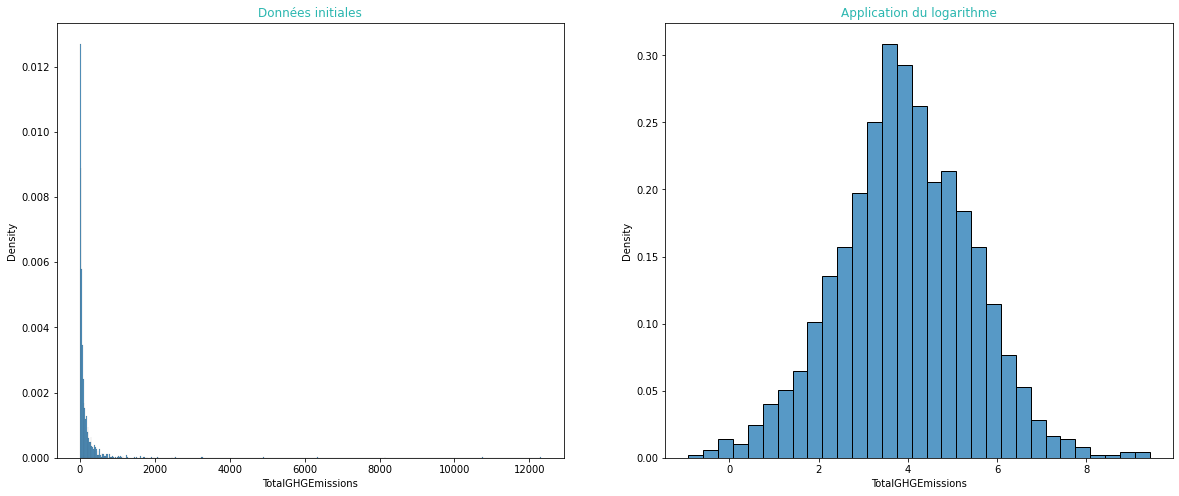

In [316]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()